In [154]:
import pandas as pd
import numpy as np
import os
import torch
import torch.nn as nn
from torch.nn import MSELoss
from torch.nn.functional import mse_loss
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import time
import glob
from compute_distance import compute_distance
from scipy.spatial import cKDTree
from shapely.geometry import Point, Polygon, LineString
from shapely.ops import unary_union

In [155]:
weights_path = 'models/test'
model = ""
data_path = 'data/unscaled_p/'
data_pattern = 'TrP4_*_10.csv'

num_epochs = 500
batch_size = 2000

loss_fn = mse_loss

h_n = 64
input_n = 4
n_layers = 8

ds = 0.4
dp = 0.1

lr = [1e-3, 1e-3, 2e-3]

In [156]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [157]:
class Swish(nn.Module):
    def forward(self, x):
        return x * torch.sigmoid(x)

# General PINN architecture for u, v, or p
class PINN(nn.Module):
    def __init__(self, input_dim=4, output_dim=1, hidden_dim=64, num_layers=8):
        super(PINN, self).__init__()
        layers = []

        # Input layer
        layers.append(nn.Linear(input_dim, hidden_dim))
        layers.append(Swish())

        # Hidden layers
        for _ in range(num_layers - 1):
            layers.append(nn.Linear(hidden_dim, hidden_dim))
            layers.append(Swish())

        # Output layer
        layers.append(nn.Linear(hidden_dim, output_dim))
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

In [158]:
def initialize_models():
    net_u = PINN(input_dim=input_n, output_dim=1, hidden_dim=h_n, num_layers=n_layers).to(device)
    net_v = PINN(input_dim=input_n, output_dim=1, hidden_dim=h_n, num_layers=n_layers).to(device)
    net_p = PINN(input_dim=input_n, output_dim=1, hidden_dim=h_n, num_layers=n_layers).to(device)

    def init_xavier(model):
        for m in model.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_normal_(m.weight)
                nn.init.zeros_(m.bias)  # or small constant like 1e-3

    net_u.apply(init_xavier)
    net_v.apply(init_xavier)
    net_p.apply(init_xavier)

    optimizer_u = optim.Adam(net_u.parameters(), lr=lr[0])
    optimizer_v = optim.Adam(net_v.parameters(), lr=lr[1])
    optimizer_p = optim.Adam(net_p.parameters(), lr=lr[2])

    scheduler_u = optim.lr_scheduler.ReduceLROnPlateau(optimizer_u, mode='min', factor=0.5, patience=50, min_lr=1e-6)
    scheduler_v = optim.lr_scheduler.ReduceLROnPlateau(optimizer_v, mode='min', factor=0.5, patience=50, min_lr=1e-6)
    scheduler_p = optim.lr_scheduler.ReduceLROnPlateau(optimizer_p, mode='min', factor=0.5, patience=50, min_lr=1e-6)

    if os.path.exists(f"{weights_path}/{model}_u.pth"):
        net_u.load_state_dict(torch.load(f"{weights_path}/{model}_u.pth"))
    if os.path.exists(f"{weights_path}/{model}_v.pth"):
        net_v.load_state_dict(torch.load(f"{weights_path}/{model}_v.pth"))
    if os.path.exists(f"{weights_path}/{model}_p.pth"):
        net_p.load_state_dict(torch.load(f"{weights_path}/{model}_p.pth"))

    return net_u, net_v, net_p, optimizer_u, optimizer_v, optimizer_p, scheduler_u, scheduler_v, scheduler_p

In [159]:
class DLD_Dataset(Dataset):
    def __init__(self, data_path, data_pattern):
        self.files = sorted(glob.glob(os.path.join(data_path, data_pattern)))
        self.data = []

        for file in self.files:
            df = pd.read_csv(file)

            inputs = df[['x', 'y', 'd', 'N']].values
            targets = df[['u', 'v', 'p']].values
            self.data.append((inputs, targets))

        self.inputs = torch.tensor(np.vstack([d[0] for d in self.data]), dtype=torch.float32)
        self.targets = torch.tensor(np.vstack([d[1] for d in self.data]), dtype=torch.float32)

    def __len__(self):
        return self.inputs.shape[0]
    
    def __getitem__(self, idx):
        return self.inputs[idx], self.targets[idx]

In [160]:
def criterion(inputs, targets, net_u, net_v, net_p, loss_fn, epoch, rho=1.0, nu=0.01, ds=0.4, dp = 0.1):
    x, y, d, n = inputs[:, 0], inputs[:, 1], inputs[:, 2], inputs[:, 3]

    x.requires_grad_()
    y.requires_grad_()
    d.requires_grad_()
    n.requires_grad_()

    input_tensor = torch.stack((x, y, d, n), dim=1)

    u_pred = net_u(input_tensor).squeeze(1)
    v_pred = net_v(input_tensor).squeeze(1)
    p_pred = net_p(input_tensor).squeeze(1)

    distances = compute_distance(x, y, d, n)

    inlet_condition = (torch.abs(x) < 1e-6)
    outlet_condition = (torch.abs(x - ds) < 1e-6)
    wall_condition = (distances < 1e-6)

    u_avg = 0.01 / d
    u_max = (3 / 2) * u_avg
    u_inlet = u_max * (1 - (4 * (((ds / 2) - y) ** 2)) / ((ds - d) ** 2))

    inlet_loss_u = mse_loss(u_pred[inlet_condition], u_inlet[inlet_condition])
    inlet_loss_v = mse_loss(v_pred[inlet_condition], torch.zeros_like(v_pred[inlet_condition]))
    inlet_loss_p = mse_loss(p_pred[inlet_condition], torch.full_like(p_pred[inlet_condition], dp))

    inlet_loss = inlet_loss_u + inlet_loss_v + inlet_loss_p

    outlet_loss_p = mse_loss(p_pred[outlet_condition], torch.zeros_like(p_pred[outlet_condition]))

    outlet_loss = outlet_loss_p

    wall_loss_u = mse_loss(u_pred[wall_condition], torch.zeros_like(u_pred[wall_condition]))
    wall_loss_v = mse_loss(v_pred[wall_condition], torch.zeros_like(v_pred[wall_condition]))

    wall_loss = wall_loss_u + wall_loss_v

    ####
    xStart = 0
    xEnd = ds

    u_hard = u_pred * distances.unsqueeze(1)
    v_hard = v_pred * distances.unsqueeze(1)

    x1 = x.unsqueeze(1)
    y1 = y.unsqueeze(1)
    p_hard = (xStart - x1)*0 + dp * (xEnd - x1) / ds + 0 * y1 + (xStart - x1) * (xEnd - x1) * p_pred

    u_x = torch.autograd.grad(u_hard, x, grad_outputs=torch.ones_like(u_hard), create_graph=True)[0]
    u_xx = torch.autograd.grad(u_x, x, grad_outputs=torch.ones_like(u_x), create_graph=True)[0]
    u_y = torch.autograd.grad(u_hard, y, grad_outputs=torch.ones_like(u_hard), create_graph=True)[0]
    u_yy = torch.autograd.grad(u_y, y, grad_outputs=torch.ones_like(u_y), create_graph=True)[0]

    v_x = torch.autograd.grad(v_hard, x, grad_outputs=torch.ones_like(v_hard), create_graph=True)[0]
    v_xx = torch.autograd.grad(v_x, x, grad_outputs=torch.ones_like(v_x), create_graph=True)[0]
    v_y = torch.autograd.grad(v_hard, y, grad_outputs=torch.ones_like(v_hard), create_graph=True)[0]
    v_yy = torch.autograd.grad(v_y, y, grad_outputs=torch.ones_like(v_y), create_graph=True)[0]

    p_x = torch.autograd.grad(p_hard, x, grad_outputs=torch.ones_like(p_hard), create_graph=True)[0]
    p_y = torch.autograd.grad(p_hard, y, grad_outputs=torch.ones_like(p_hard), create_graph=True)[0]

    pde_loss_x = u_hard * u_x + v_hard * u_y - nu * (u_xx + u_yy) + (1 / rho) * p_x
    pde_loss_y = u_hard * v_x + v_hard * v_y - nu * (v_xx + v_yy) + (1 / rho) * p_y
    pde_loss_continuity = u_x + v_y 

    pde_loss_x = loss_fn(pde_loss_x, torch.zeros_like(pde_loss_x))
    pde_loss_y = loss_fn(pde_loss_y, torch.zeros_like(pde_loss_y))
    pde_loss_continuity = loss_fn(pde_loss_continuity, torch.zeros_like(pde_loss_continuity))
    ####
    
    loss_u = loss_fn(u_pred, targets[:, 0])
    loss_v = loss_fn(v_pred, targets[:, 1])
    loss_p = loss_fn(p_pred, targets[:, 2])

    boundaries_weight = 0 if epoch < 300 else 100
    
    total_loss = loss_u + loss_v + loss_p + boundaries_weight * (inlet_loss + outlet_loss + wall_loss)

    return total_loss, loss_u, loss_v, loss_p,\
        inlet_loss, outlet_loss, wall_loss, \
        pde_loss_x, pde_loss_y, pde_loss_continuity

In [161]:
def main():
    dataset = DLD_Dataset(data_path, data_pattern)
    print(f"Dataset size: {len(dataset)}")

    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    print(f"Number of batches: {len(dataloader)}")

    net_u, net_v, net_p, optimizer_u, optimizer_v, optimizer_p, scheduler_u, scheduler_v, scheduler_p = initialize_models()

    min_loss = float('inf')

    loss_history = {
        'epoch': [],
        'total_loss': [],
        'loss_u': [],
        'loss_v': [],
        'loss_p': [],
        'inlet_loss': [],
        'outlet_loss': [],
        'wall_loss': [],
        'pde_loss_x': [],
        'pde_loss_y': [],
        'pde_loss_continuity': [],
    }

    start_time = time.time()

    for epoch in range(num_epochs+1):
        total_loss, total_loss_u, total_loss_v, total_loss_p, \
            total_inlet_loss, total_outlet_loss, total_wall_loss, \
            total_pde_loss_x, total_pde_loss_y, total_pde_loss_continuity = 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0

        for inputs, targets in dataloader:
            inputs, targets = inputs.to(device), targets.to(device)

            optimizer_u.zero_grad()
            optimizer_v.zero_grad()
            optimizer_p.zero_grad()

            loss, loss_u, loss_v, loss_p, \
                inlet_loss, outlet_loss, wall_loss, \
                pde_loss_x, pde_loss_y, pde_loss_continuity = criterion(inputs, targets, net_u, net_v, net_p, loss_fn, epoch, ds=ds, dp=dp)

            loss.backward()

            optimizer_u.step()
            optimizer_v.step()
            optimizer_p.step()

            total_loss += loss.item()
            total_loss_u += loss_u.item()
            total_loss_v += loss_v.item()
            total_loss_p += loss_p.item()

            total_inlet_loss += inlet_loss.item()
            total_outlet_loss += outlet_loss.item()
            total_wall_loss += wall_loss.item()

            total_pde_loss_x += pde_loss_x.item()
            total_pde_loss_y += pde_loss_y.item()
            total_pde_loss_continuity += pde_loss_continuity.item()

        total_loss_u /= len(dataloader)
        total_loss_v /= len(dataloader)
        total_loss_p /= len(dataloader)
        total_pde_loss_x /= len(dataloader)
        total_pde_loss_y /= len(dataloader)
        total_pde_loss_continuity /= len(dataloader)
        total_loss /= len(dataloader)

        scheduler_u.step(total_loss_u)
        scheduler_v.step(total_loss_v)
        scheduler_p.step(total_loss_p)

        loss_history['epoch'].append(epoch)
        loss_history['total_loss'].append(total_loss)
        loss_history['loss_u'].append(total_loss_u)
        loss_history['loss_v'].append(total_loss_v)
        loss_history['loss_p'].append(total_loss_p)

        loss_history['inlet_loss'].append(total_inlet_loss)
        loss_history['outlet_loss'].append(total_outlet_loss)
        loss_history['wall_loss'].append(total_wall_loss)

        loss_history['pde_loss_x'].append(total_pde_loss_x)
        loss_history['pde_loss_y'].append(total_pde_loss_y)
        loss_history['pde_loss_continuity'].append(total_pde_loss_continuity)

        print(f"Epoch {epoch}/{num_epochs}, Total Loss: {total_loss:.4f} || Loss U: {total_loss_u:.4f}, Loss V: {total_loss_v:.4f}, Loss P: {total_loss_p:.4f} "
            f"|| Inlet Loss: {total_inlet_loss:.4f}, Outlet Loss: {total_outlet_loss:.4f}, Wall Loss: {total_wall_loss:.4f} "
            f"|| PDE Losses: x: {total_pde_loss_x:.4f}, y: {total_pde_loss_y:.4f}, continuity: {total_pde_loss_continuity:.4f} || Time: {time.time() - start_time:.2f}s")

        start_time = time.time()

        if total_loss < min_loss:
            min_loss = total_loss
            torch.save(net_u.state_dict(), f"{weights_path}/best_u.pth")
            torch.save(net_v.state_dict(), f"{weights_path}/best_v.pth")
            torch.save(net_p.state_dict(), f"{weights_path}/best_p.pth")
            print(f"New best model saved with loss: {min_loss:.4f}")

        if epoch % 100 == 0:
            torch.save(net_u.state_dict(), f"{weights_path}/epoch_{epoch}_u.pth")
            torch.save(net_v.state_dict(), f"{weights_path}/epoch_{epoch}_v.pth")
            torch.save(net_p.state_dict(), f"{weights_path}/epoch_{epoch}_p.pth")
            print(f"Checkpoint saved at epoch {epoch}")

    loss_df = pd.DataFrame(loss_history)
    loss_df.to_csv(f"results/test/test_loss_history.csv", index=False)

    plt.figure(figsize=(10, 6))
    plt.plot(loss_history['epoch'], loss_history['loss_u'], label='Loss U', color='blue')
    plt.plot(loss_history['epoch'], loss_history['loss_v'], label='Loss V', color='orange')
    plt.plot(loss_history['epoch'], loss_history['loss_p'], label='Loss P', color='green')
    plt.plot(loss_history['epoch'], loss_history['total_loss'], label='Total Loss', color='red')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss History')
    plt.legend()
    plt.grid()
    plt.savefig(f"results/test/test_loss_history.png")
    plt.show()

    print("Training complete.")

Dataset size: 99603
Number of batches: 50
Epoch 0/500, Total Loss: 0.0126 || Loss U: 0.0114, Loss V: 0.0005, Loss P: 0.0007 || Inlet Loss: 0.2859, Outlet Loss: 0.1788, Wall Loss: 0.4824 || PDE Losses: x: 269805.4188, y: 112.0540, continuity: 18768.0340 || Time: 2.15s
New best model saved with loss: 0.0126
Checkpoint saved at epoch 0
Epoch 1/500, Total Loss: 0.0120 || Loss U: 0.0110, Loss V: 0.0005, Loss P: 0.0005 || Inlet Loss: 0.2707, Outlet Loss: 0.1765, Wall Loss: 0.4761 || PDE Losses: x: 269469.7706, y: 6.4298, continuity: 18585.0899 || Time: 2.29s
New best model saved with loss: 0.0120
Epoch 2/500, Total Loss: 0.0105 || Loss U: 0.0095, Loss V: 0.0005, Loss P: 0.0005 || Inlet Loss: 0.3349, Outlet Loss: 0.1604, Wall Loss: 0.5495 || PDE Losses: x: 271059.2541, y: 5.5792, continuity: 19937.5670 || Time: 2.07s
New best model saved with loss: 0.0105
Epoch 3/500, Total Loss: 0.0091 || Loss U: 0.0081, Loss V: 0.0005, Loss P: 0.0005 || Inlet Loss: 0.3466, Outlet Loss: 0.1342, Wall Loss: 0.

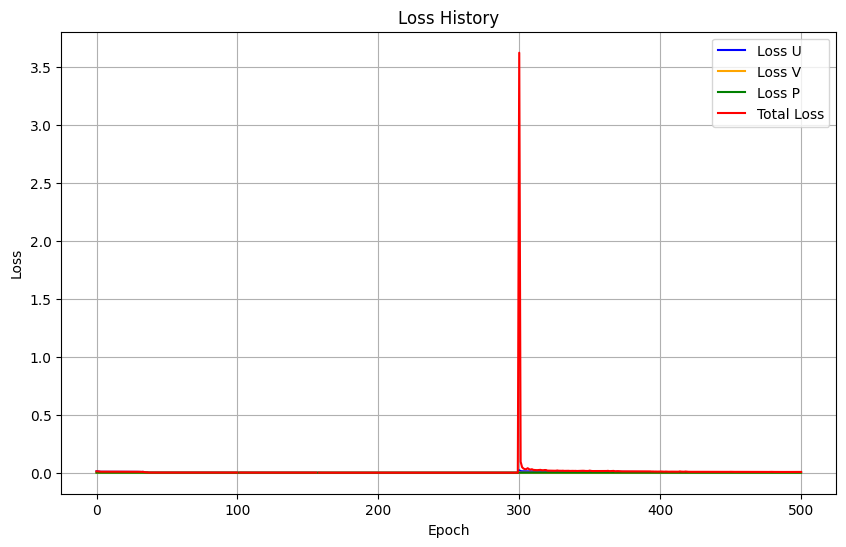

Training complete.


In [162]:
if __name__ == "__main__":
    main()